In [17]:
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import label

model = YOLO("runs/segment/train/weights/best.pt")

In [18]:
results = model.predict("../data/D000_sala_de_aula/20230525_165517.jpg")


image 1/1 c:\Users\LeonardoScholler\Desktop\pucrs_am_t2\code\..\data\D000_sala_de_aula\20230525_165517.jpg: 640x288 1 bottle, 1 dining table, 129.8ms
Speed: 2.0ms preprocess, 129.8ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)


In [19]:
for item in results:
    for i, box in enumerate(item.boxes):
        if(box.cls == 39):
            bottle = item
            class_index = i

WARNING ⚠️ 'Masks.masks' is deprecated. Use 'Masks.data' instead.


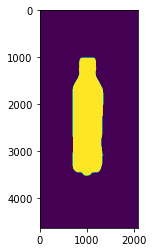

In [20]:
resized_mask = cv2.resize(bottle.masks.masks[class_index].numpy(), (bottle.orig_img.shape[1], bottle.orig_img.shape[0])).astype(bool)
plt.imshow(resized_mask)

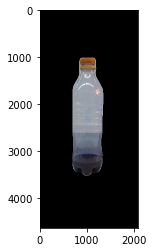

In [21]:
masked_image = bottle.orig_img * resized_mask[:, :, np.newaxis]
plt.imshow(masked_image)

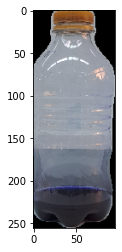

In [22]:
non_zero_pixels = np.where(np.any(masked_image != 0, axis=-1))
min_y = np.min(non_zero_pixels[0])
max_y = np.max(non_zero_pixels[0])
min_x = np.min(non_zero_pixels[1])
max_x = np.max(non_zero_pixels[1])

masked_image = masked_image[min_y:max_y, min_x:max_x]
masked_image = cv2.resize(masked_image, (96, 256)) # resize to a common size of a bottle
plt.imshow(masked_image)

Bottle height 256
Average top color: [     157.61      161.72      169.28]


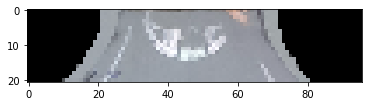

In [23]:
bottle_height = np.shape(masked_image)[0]
print(f"Bottle height {bottle_height}")

top_section = masked_image[int(bottle_height * 0.12):int(bottle_height * 0.2),:,:]
top_color = np.array([
    top_section[:,:,0][top_section[:,:,0] != 0].mean(), 
    top_section[:,:,1][top_section[:,:,1] != 0].mean(), 
    top_section[:,:,2][top_section[:,:,2] != 0].mean()
])
plt.imshow(top_section)
print(f"Average top color: {top_color}")

Average bottom color: [     44.086      43.562      50.684]


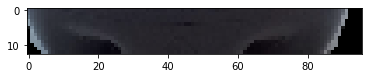

In [24]:
bottom_section = masked_image[int(bottle_height * 0.9):int(bottle_height * 0.95),:,:]
bottom_color = np.array([
    bottom_section[:,:,0][bottom_section[:,:,0] != 0].mean(), 
    bottom_section[:,:,1][bottom_section[:,:,1] != 0].mean(), 
    bottom_section[:,:,2][bottom_section[:,:,2] != 0].mean()
])
plt.imshow(bottom_section)
print(f"Average bottom color: {bottom_color}")

In [25]:
distance = np.linalg.norm(bottom_color - top_color) # color difference
max_distance = 255 * 3 ** (1/2) # maximum difference
step_size =  255 / max_distance

print(f"Distance {distance}")
if(distance > 30):
    print("Need to think more")
else:
    print("Bottle is empty or full")

Distance 202.27113847568995
Need to think more


254
(256, 96)


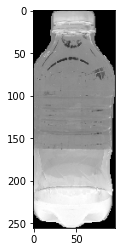

In [26]:
img = np.apply_along_axis(lambda x: abs(np.linalg.norm(bottom_color - x) * step_size - 255) if np.sum(x) != 0 else 0, axis=2, arr=masked_image).astype(int) # expensive function
print(np.max(img))
print(np.shape(img))
plt.imshow(img, cmap="gray")

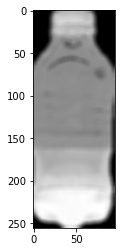

In [27]:
img = cv2.blur(src=img, ksize=(7, 7))
plt.imshow(img, cmap="gray")

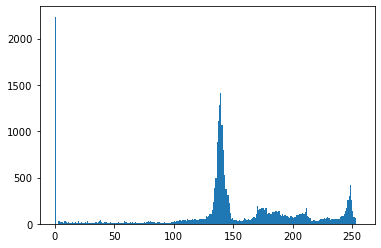

In [28]:
plt.hist(img.ravel(), 256,[0, 256]); 
plt.show()

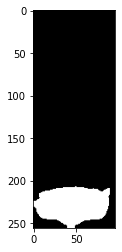

In [29]:
threshold = img > 220
plt.imshow(threshold, cmap="gray")

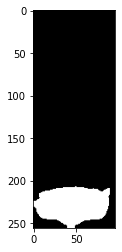

In [30]:

labeled_array, num_features = label(threshold)
labels, counts = np.unique(labeled_array, return_counts=True)

counts = counts[1:]
labels = labels[1:]

largest_cluster_label = labels[np.argmax(counts)]
largest_cluster = labeled_array == largest_cluster_label

plt.imshow(largest_cluster, cmap="gray")

Liquid height 48


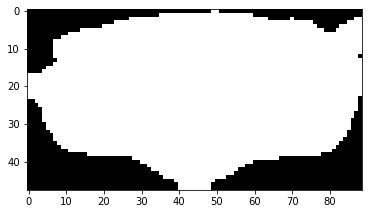

In [31]:
valid = np.where(largest_cluster)
min_y = np.min(valid[0])
max_y = np.max(valid[0])
min_x = np.min(valid[1])
max_x = np.max(valid[1])

final_image = largest_cluster[min_y:max_y, min_x:max_x]
liquid_height = np.shape(final_image)[0]
plt.imshow(final_image, cmap="gray")
print(f"Liquid height {liquid_height}")

In [32]:
print(f"Filled at {int((liquid_height / bottle_height) * 100)}%")

Filled at 18%
